In [3]:
# 30 May 2022

In [4]:
import numpy as np 
import matplotlib.pyplot as plt
import time
from open_gym_buoy_with_wind import OceanScape 
import cv2

In [5]:
from collections import namedtuple, deque
from itertools import count
from PIL import Image

In [6]:

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


/home/nrw/v3/lib/python3.8/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


self.canvas_size=array([300, 600]) self.grid_width=50 self.wind_grid_shape=array([ 6, 12])
hurray! in goal region (4, 50), posit 44, 30, dist 44.721359549995796
reached goal, final return 0.20806632868710723


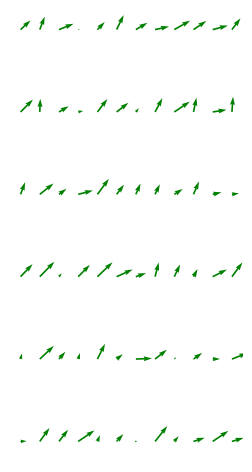

In [7]:
env = OceanScape()
obs = env.reset()

while True:
    # Take a random action
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)

    # Render the game
    env.render()
    #plt.show()

    if done == True:
        cv2.waitKey(0)
        break

env.close()

# TODO: add wind affect on batt
#       + create wind region, reset wind region, 
#       + add effect on battery, and 
# TODO: plot wind region

In [8]:
plt.ion()

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [10]:
from stable_baselines3 import A2C

In [11]:
env = OceanScape()

self.canvas_size=array([300, 600]) self.grid_width=50 self.wind_grid_shape=array([ 6, 12])


/home/nrw/v3/lib/python3.8/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


In [12]:
from tqdm.auto import tqdm

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


test progress bar:   8%|▊         | 78/1000 [00:03<00:39, 23.29it/s]


KeyboardInterrupt: 

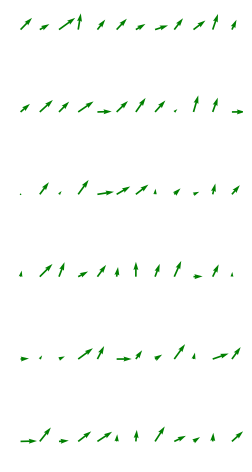

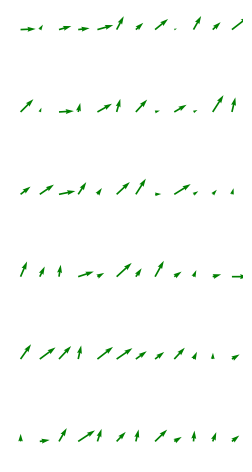

In [15]:
model = A2C('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=1)

obs = env.reset()
for i in tqdm(range(1000), desc='test progress bar'):
  action, _state = model.predict(obs, deterministic=True)
  obs, reward, done, info = env.step(action)
  env.render()
  if done:
    obs = env.reset()